# Time series prediction using Support Vector Regressor

In this notebook, we demonstrate how to:

- prepare 2D time series data for training an SVM regressor model
- implement SVR using RBF kernel
- evaluate the model using plots and MAPE

## Importing modules

In [1]:
import sys
sys.path.append('../../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from common.utils import load_data, mape

## Preparing data

### Load data

In [3]:
energy = load_data('../../data')[['load']]
energy.head(5)

a:\EDUCATION\ML-Starter\7-TimeSeries\3-SVR\solution\../..\common\utils.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  energy = energy.reindex(pd.date_range(min(energy['timestamp']),


,load
2012-01-01 00:00:00,2698.0
2012-01-01 01:00:00,2558.0
2012-01-01 02:00:00,2444.0
2012-01-01 03:00:00,2402.0
2012-01-01 04:00:00,2403.0


### Plot the data

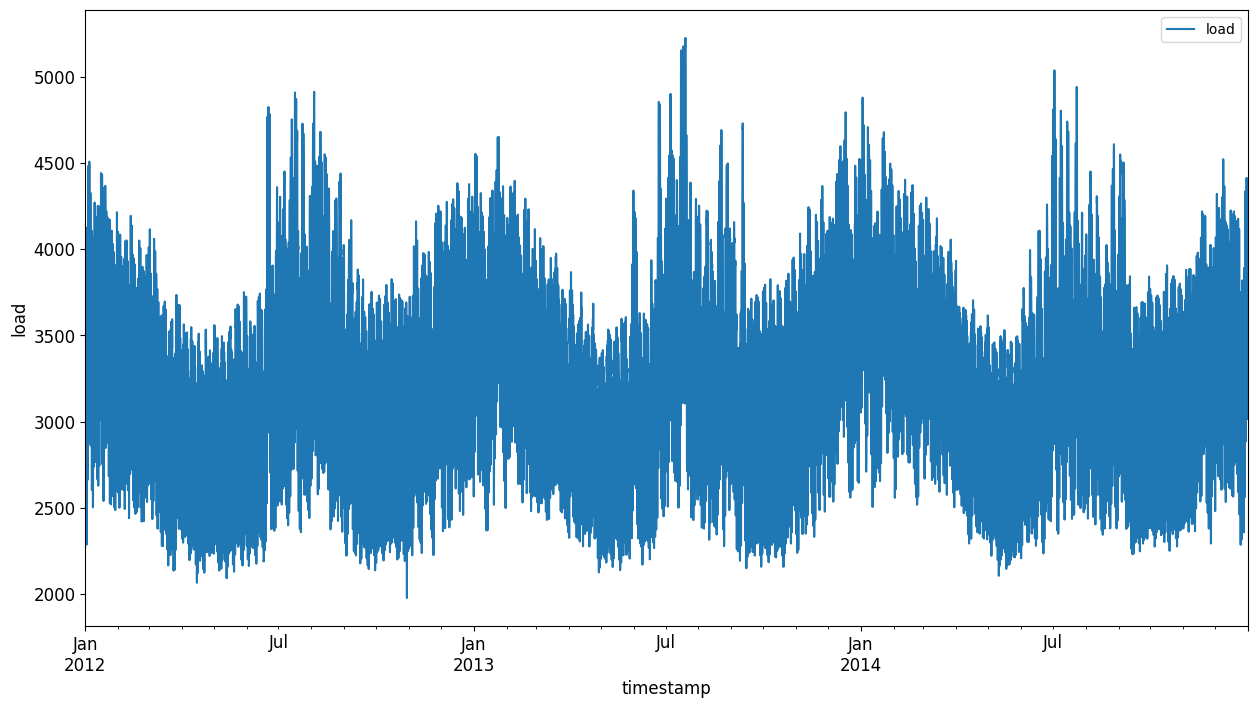

In [4]:
energy.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

### Create training and testing data

In [5]:
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'

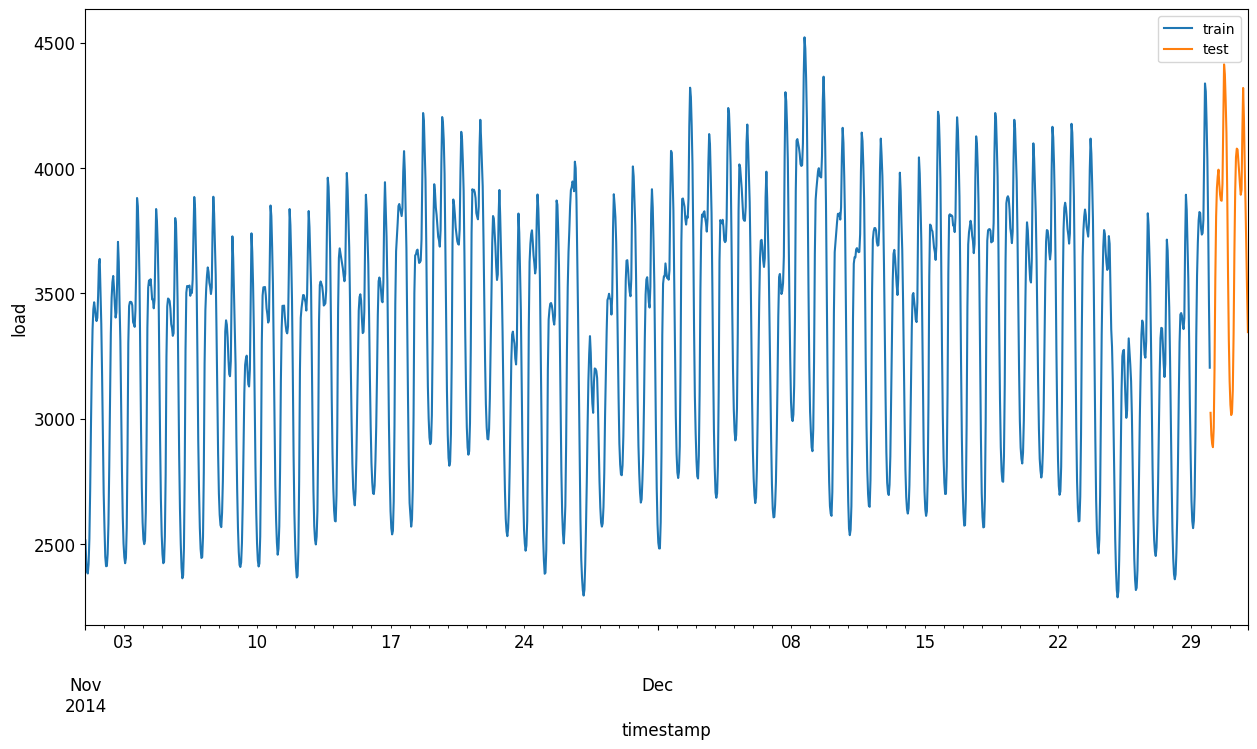

In [6]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

### Preparing data for training

Now, you need to prepare the data for training by performing filtering and scaling of your data.

In [7]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


Scale the data to be in the range (0, 1).

In [8]:
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(5)

,load
2014-11-01 00:00:00,0.101611
2014-11-01 01:00:00,0.065801
2014-11-01 02:00:00,0.046106
2014-11-01 03:00:00,0.042525
2014-11-01 04:00:00,0.059087


In [9]:
test['load'] = scaler.transform(test)
test.head(5)

,load
2014-12-30 00:00:00,0.329454
2014-12-30 01:00:00,0.290063
2014-12-30 02:00:00,0.273948
2014-12-30 03:00:00,0.268129
2014-12-30 04:00:00,0.302596


### Creating data with time-steps

 For our SVR, we transform the input data to be of the form `[batch, timesteps]`. So, we reshape the existing `train_data` and `test_data` such that there is a new dimension which refers to the timesteps. For our example, we take `timesteps = 5`. So, the inputs to the model are the data for the first 4 timesteps, and the output will be the data for the 5<sup>th</sup> timestep.

In [10]:
# Converting to numpy arrays

train_data = train.values
test_data = test.values

In [11]:
# Selecting the timesteps

timesteps=5

In [12]:
# Converting data to 2D tensor

train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(1412, 5)

In [13]:
# Converting test data to 2D tensor

test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(44, 5)

In [14]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1412, 4) (1412, 1)
(44, 4) (44, 1)


## Creating SVR model

In [15]:
# Create model using RBF kernel

model = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)

In [16]:
# Fit model on training data

model.fit(x_train, y_train[:,0])

SVR(C=10, epsilon=0.05, gamma=0.5)

### Make model prediction

In [17]:
# Making predictions

y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(1412, 1) (44, 1)


## Analyzing model performance

In [18]:
# Scaling the predictions

y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

print(len(y_train_pred), len(y_test_pred))

1412 44


In [19]:
# Scaling the original values

y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

print(len(y_train), len(y_test))

1412 44


In [20]:
# Extract the timesteps for x-axis

train_timestamps = energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = energy[test_start_dt:].index[timesteps-1:]

print(len(train_timestamps), len(test_timestamps))

1412 44


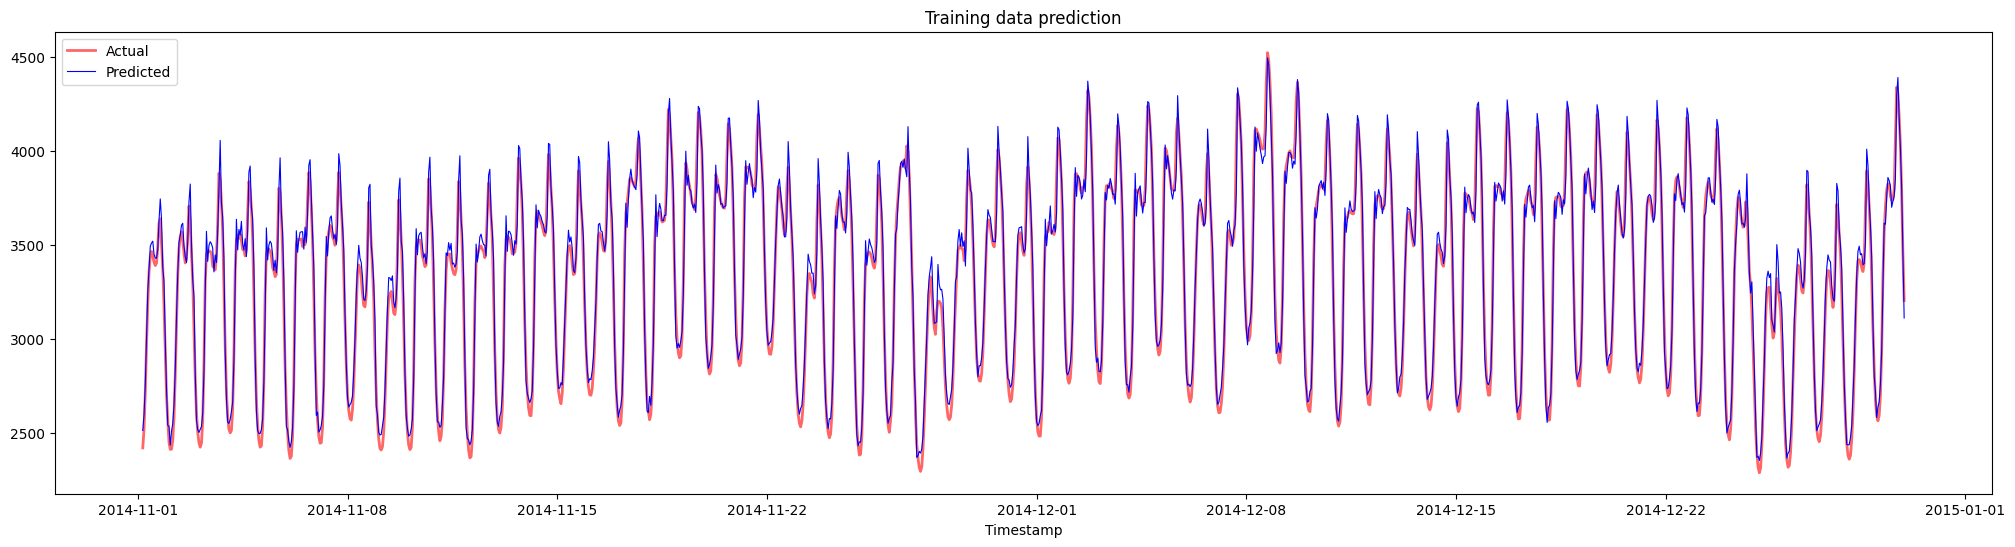

In [21]:
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.show()

In [22]:
print('MAPE for training data: ', mape(y_train_pred, y_train)*100, '%')

MAPE for training data:  1.7195710200875551 %


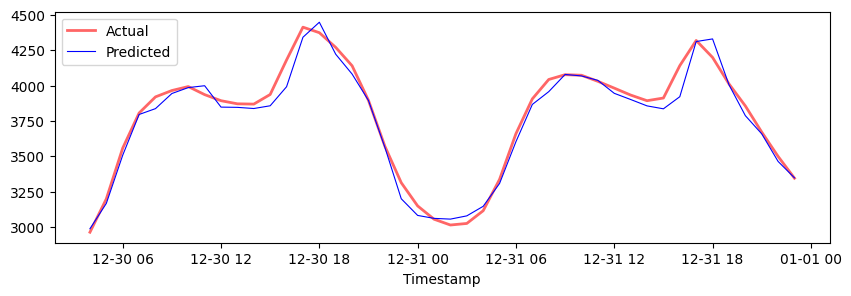

In [23]:
plt.figure(figsize=(10,3))
plt.plot(test_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

In [24]:
print('MAPE for testing data: ', mape(y_test_pred, y_test)*100, '%')

MAPE for testing data:  1.2623790187854018 %


## Full dataset prediction

In [25]:
# Extracting load values as numpy array
data = energy.copy().values

# Scaling
data = scaler.transform(data)

# Transforming to 2D tensor as per model input requirement
data_timesteps=np.array([[j for j in data[i:i+timesteps]] for i in range(0,len(data)-timesteps+1)])[:,:,0]
print("Tensor shape: ", data_timesteps.shape)

# Selecting inputs and outputs from data
X, Y = data_timesteps[:,:timesteps-1],data_timesteps[:,[timesteps-1]]
print("X shape: ", X.shape,"\nY shape: ", Y.shape)

Tensor shape:  (26300, 5)
X shape:  (26300, 4) 
Y shape:  (26300, 1)


a:\EDUCATION\ML-Starter\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [26]:
# Make model predictions
Y_pred = model.predict(X).reshape(-1,1)

# Inverse scale and reshape
Y_pred = scaler.inverse_transform(Y_pred)
Y = scaler.inverse_transform(Y)

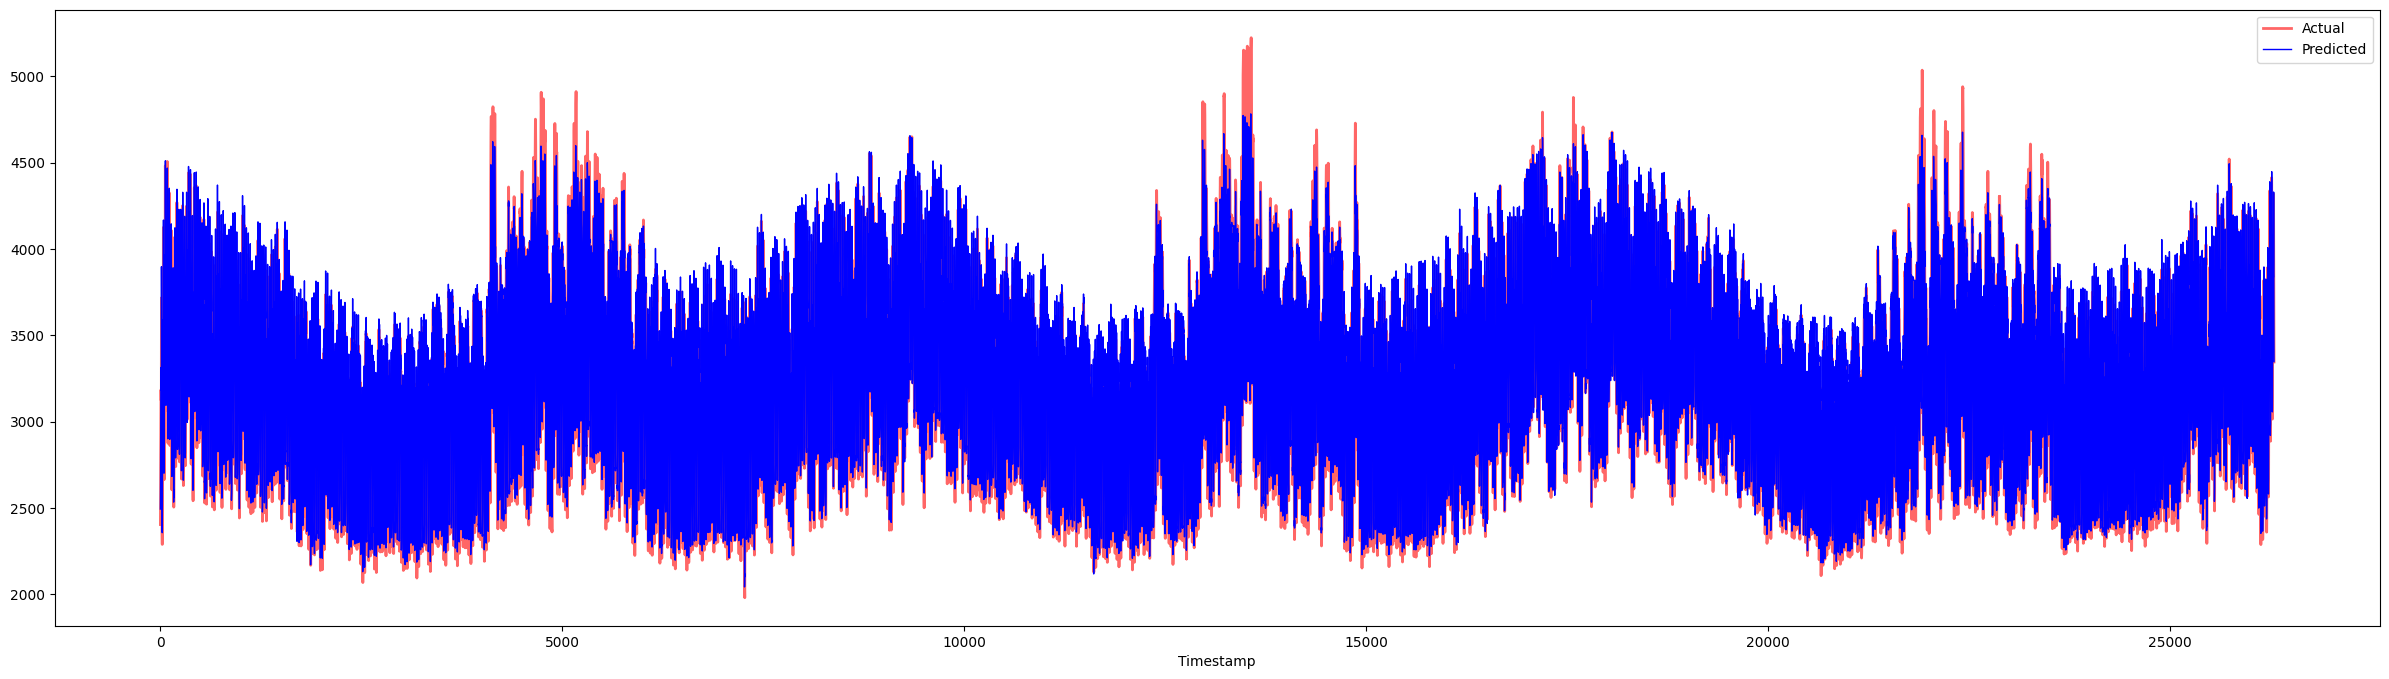

In [27]:
plt.figure(figsize=(30,8))
plt.plot(Y, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(Y_pred, color = 'blue', linewidth=1)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

In [28]:
print('MAPE: ', mape(Y_pred, Y)*100, '%')

MAPE:  2.0572089029888656 %
